In [12]:
%matplotlib inline
%load_ext autoreload
%autoreload
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import numpy.ma as ma
import struct
import os
import xarray as xr
import glob
import datetime 
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import seaborn as sns
import pandas as pd
import itertools

# ESIO Imports
import esio
import esiodata as ed

import dask
dask.set_options(get=dask.threaded.get)
# from dask.distributed import Client, progress
# client = Client(processes=12)

# General plotting settings
sns.set_style('ticks')
sns.set_context("talk", font_scale=1.5, rc={"lines.linewidth": 2.5})

plt.rcParams.update({'figure.max_open_warning': 0})

#############################################################
# Load in Data
#############################################################
E = ed.esiodata.load()
data_dir = E.data_dir
grid_dir = E.grid_dir
fig_dir = os.path.join(E.fig_dir, 'metrics', 'extent')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
runType = 'forecast'
variables = ['sic']
cvar = variables[0]

In [3]:
# Define models to plot
models_2_plot = list(E.model.keys())
models_2_plot = [x for x in models_2_plot if x!='piomas'] # remove some models
# models_2_plot = ['gfdlsipn']

## First, plot each model's (difference from obs, RMSE with initilization time, RMSE with forecast time, and Extent plots

gfdlsipn
yopp
bom
cma


KeyboardInterrupt: 

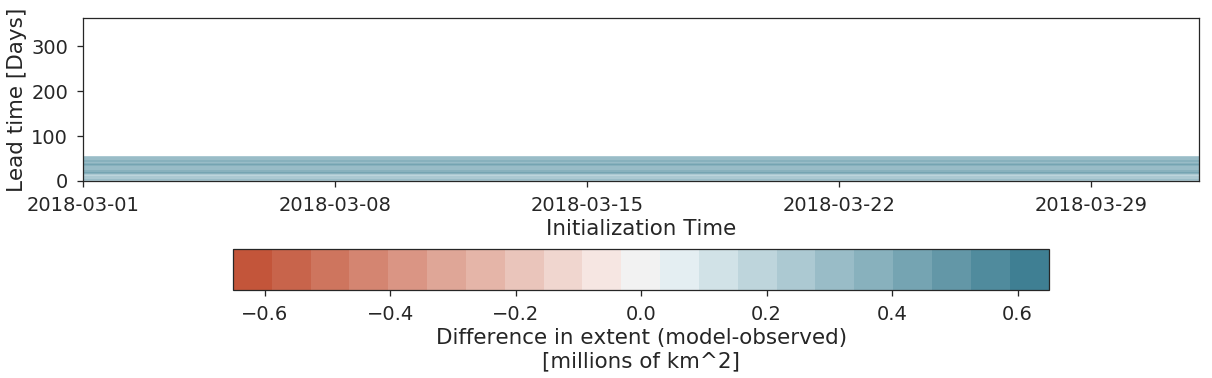

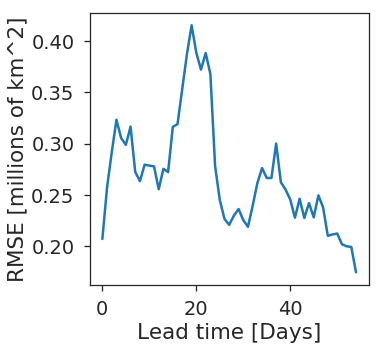

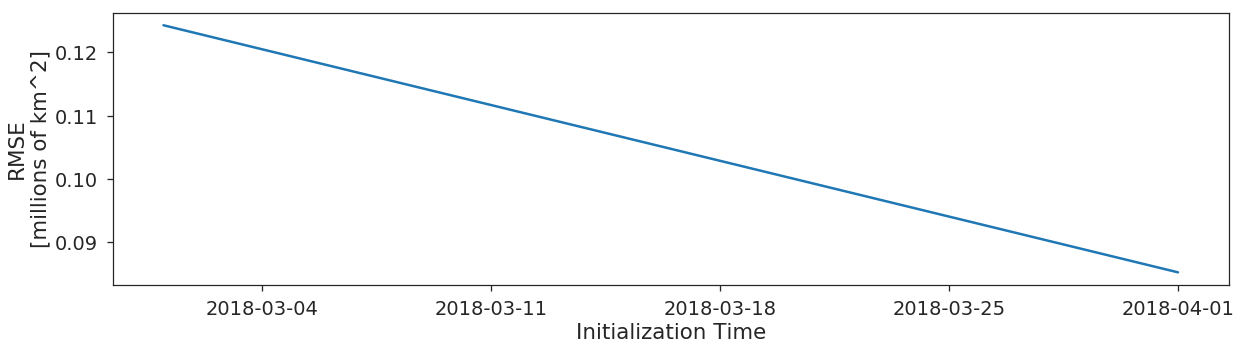

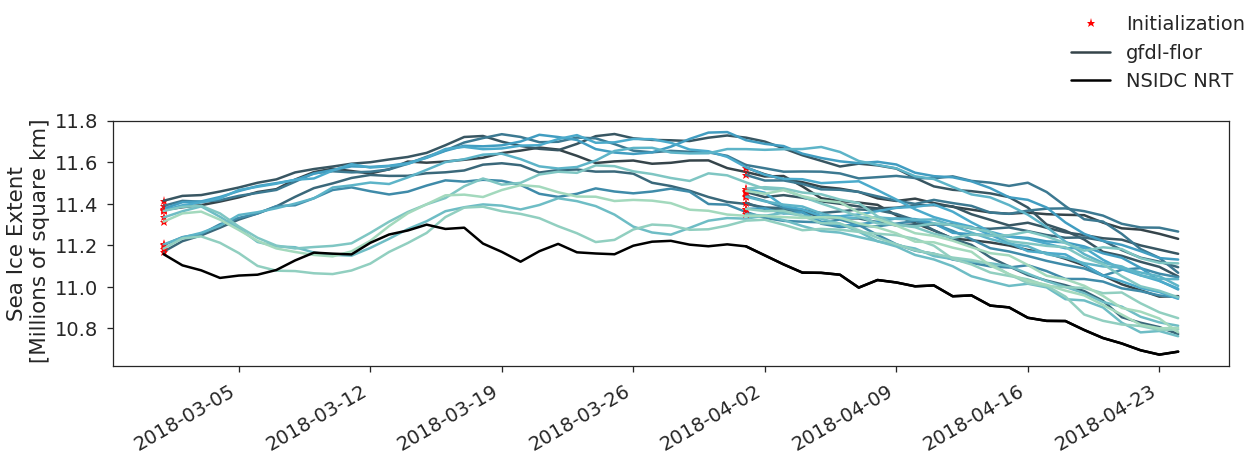

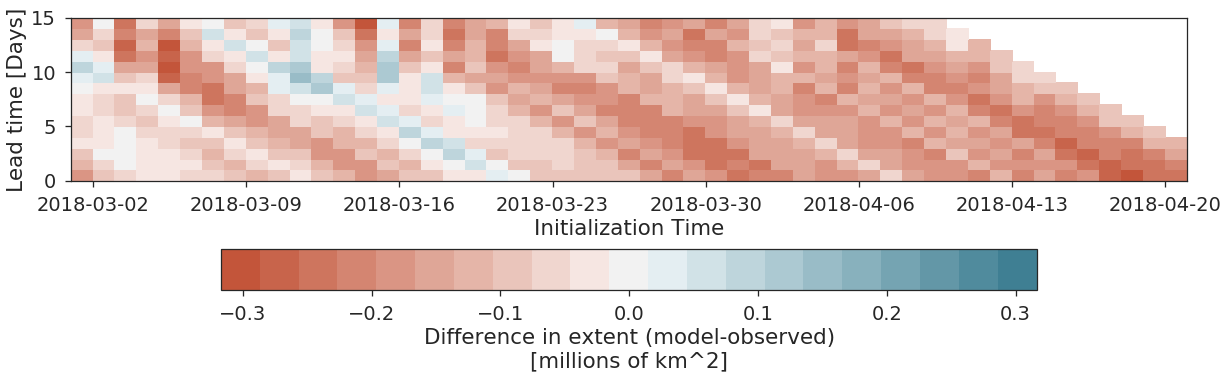

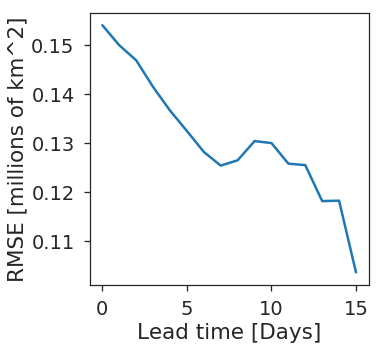

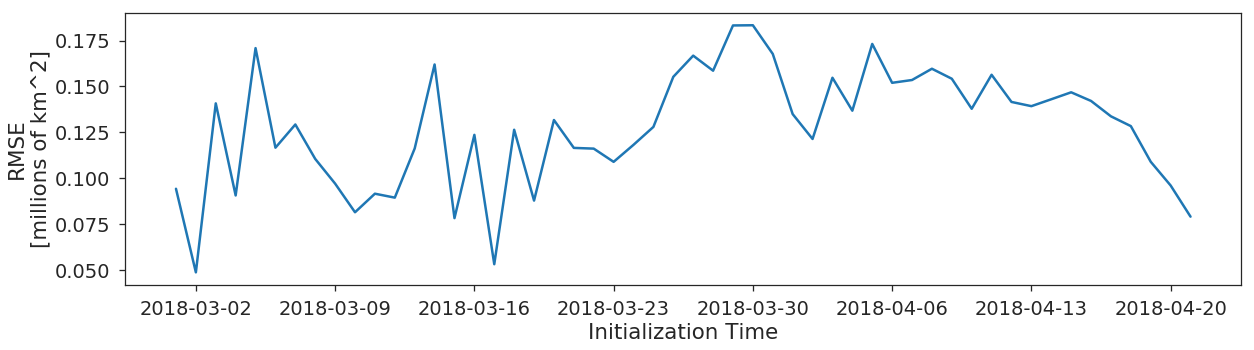

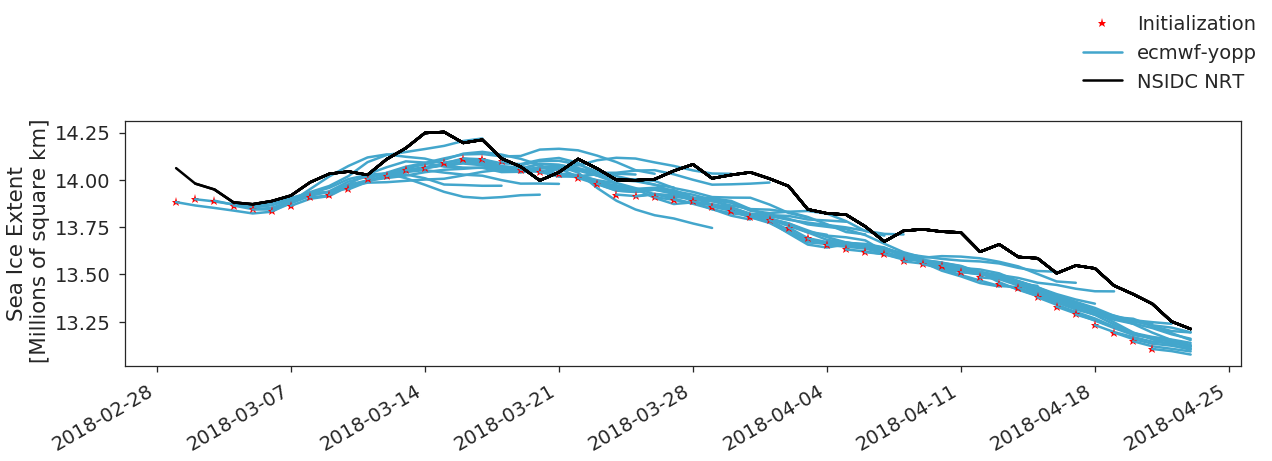

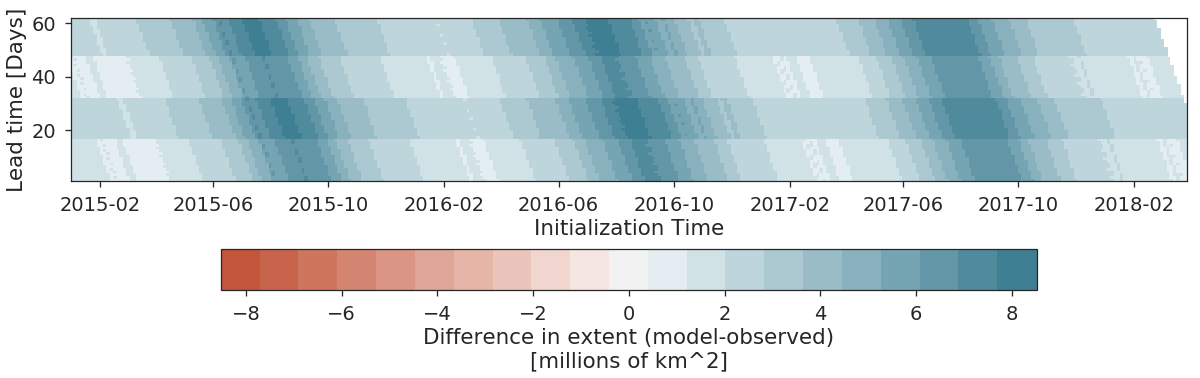

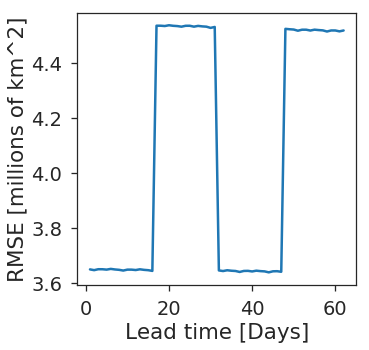

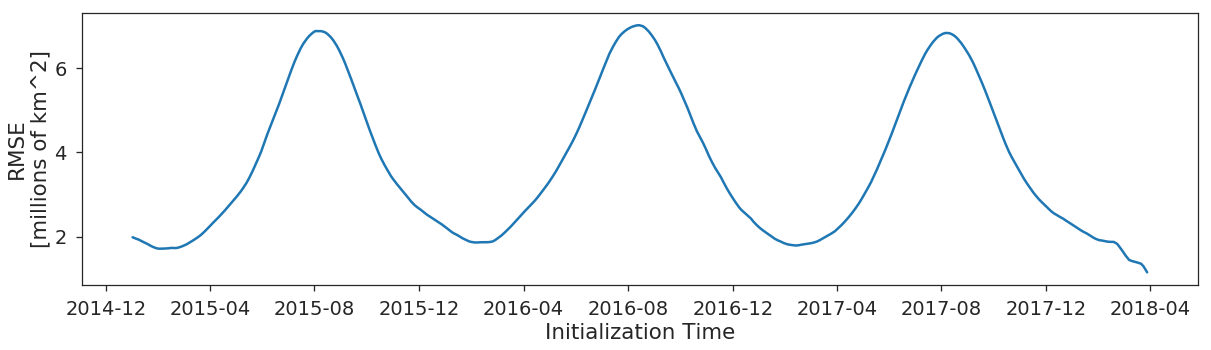

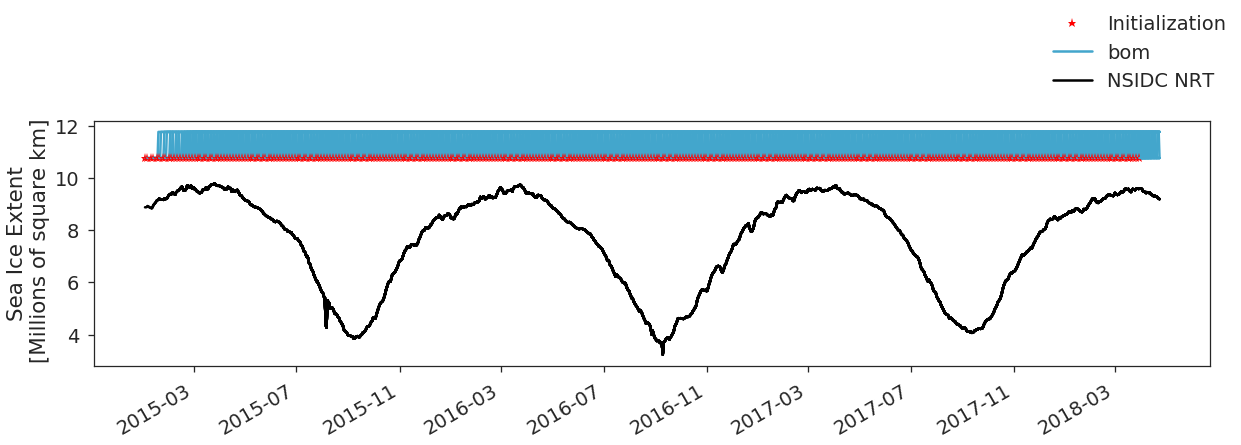

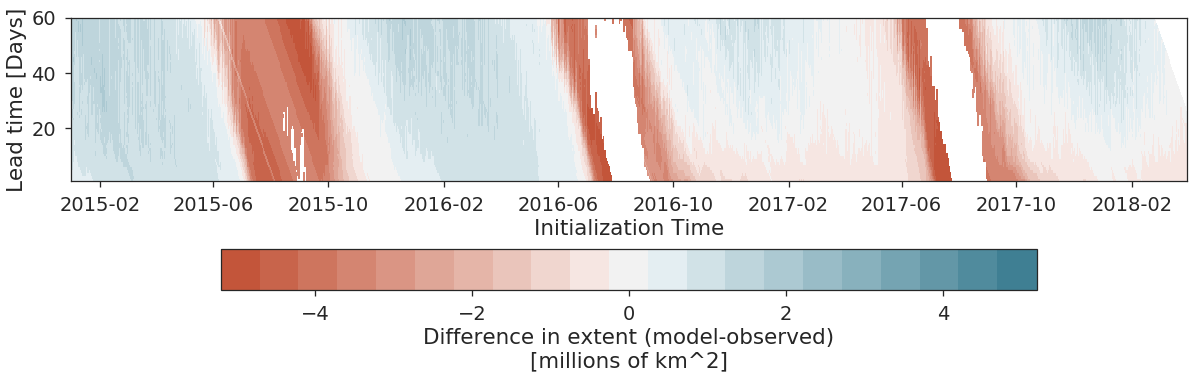

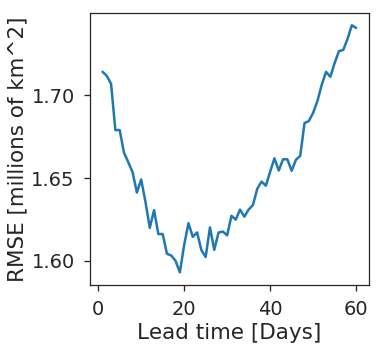

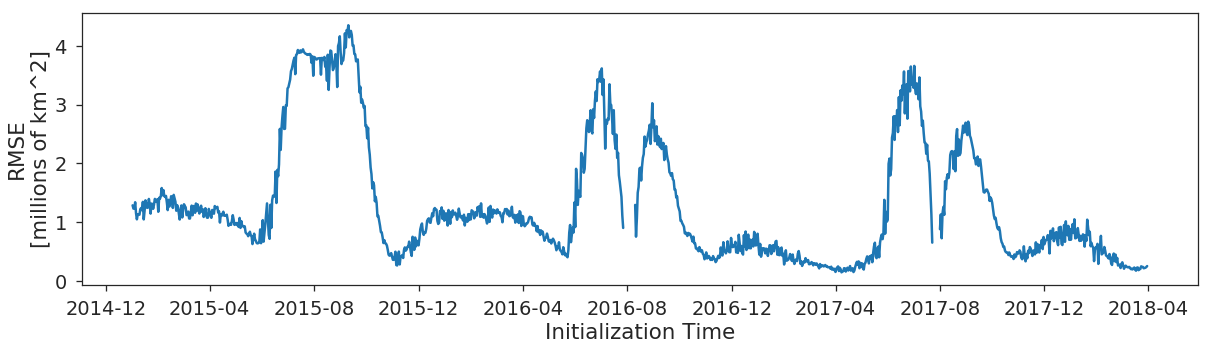

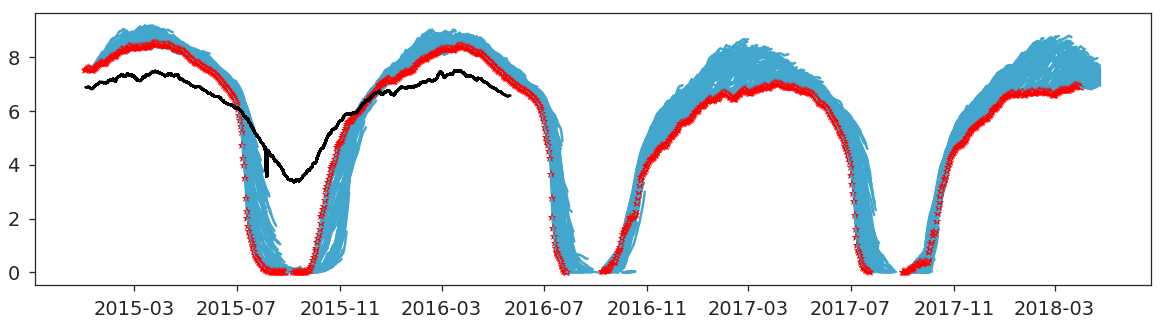

In [4]:
for (i, c_model) in enumerate(models_2_plot):
    print(c_model)
    
    # Load in data
    # Check file exists
    nc_file = os.path.join(data_dir, 'model', c_model , 'forecast', 'agg_nc', c_model+'_extent.nc')
    if os.path.isfile(nc_file):
        ds_mrg = xr.open_dataset(nc_file)
    else:
        print('No file found... skipping...')
        continue

    # Plotting color maps
    cmap_diff = matplotlib.colors.ListedColormap(sns.diverging_palette(20,  220, n=21))
    # Calculate differences for each ensemble (0...N) from obseerved (-1)
    MOdiff = (ds_mrg[cvar].sel(ensemble=slice(0,ds_mrg.ensemble.size)) - ds_mrg[cvar].sel(ensemble=-1) )
    abs_max = np.max([MOdiff.min()*-1, MOdiff.max()])
    # Take average of ensemble and remove any times where we have no data in ensemble dim (missing obs)
    MOdiff_avg = MOdiff.mean(dim='ensemble')

    # Calc RMSE
    rmse_fore_time = np.sqrt( ( esio.nanSum(da=MOdiff_avg**2, dim='init_time')/MOdiff_avg.init_time.size) ).values
    rmse_init_time = np.sqrt( ( esio.nanSum(da=MOdiff_avg**2, dim='fore_time')/MOdiff_avg.fore_time.size) ).values

    plt.figure(figsize=(20,5))
    plt.pcolormesh(ds_mrg.init_time.values, ds_mrg.fore_time.values.astype('timedelta64[D]').astype('int'), 
                   MOdiff_avg.T.values,
                  cmap=cmap_diff, vmin=-1*abs_max, vmax=abs_max)
    plt.ylabel('Lead time [Days]')
    plt.xlabel('Initialization Time')
    cb = plt.colorbar(orientation='horizontal', label='Difference in extent (model-observed)\n[millions of km^2]', pad=0.25)

    
    
    plt.figure(figsize=(5,5))
    plt.plot(MOdiff.fore_time.values.astype('timedelta64[D]').astype('int'), rmse_fore_time)
    plt.ylabel('RMSE [millions of km^2]')
    plt.xlabel('Lead time [Days]')

    
    
    
    plt.figure(figsize=(20,5))
    plt.plot(MOdiff.init_time.values, rmse_init_time)
    plt.ylabel('RMSE\n[millions of km^2]')
    plt.xlabel('Initialization Time')

    
    
    
    # Plot pan-Arctic sea ice extent
    f = plt.figure(figsize=(20,5))
    ax1 = plt.subplot(1, 1, 1) # Observations
    esio.plot_reforecast(ds=ds_mrg.sel(ensemble=slice(0,ds_mrg.ensemble.size)).sic, 
                         axin=ax1, labelin=E.model[c_model]['model_label'],
                         color='cycle_ensemble', marker=None)
    esio.plot_reforecast(ds=ds_mrg.sel(ensemble=-1).sic.expand_dims('ensemble'), 
                     axin=ax1, labelin='NSIDC NRT',
                     color='k', marker=None, init_dot=False)
#     ds_mrg.sel(ensemble=-1).sic.plot(label='NSIDC NRT', color='k')
    # ds_ext.Extent.plot(label='NSIDC V3', color='m')
    ax1.set_ylabel('Sea Ice Extent\n [Millions of square km]')
    plt.legend(loc='lower right',bbox_to_anchor=(1.03, 1.05))
    f.autofmt_xdate()
    plt.title('')

'/home/disk/sipn/nicway/public_html/sipn/figures/metrics/adjusted'

## Now, combine multiple models on each plot

gfdlsipn
yopp
cma
ecmwf
metreofr
ukmo
kma
ncep
ukmetofficesipn
ecmwfsipn


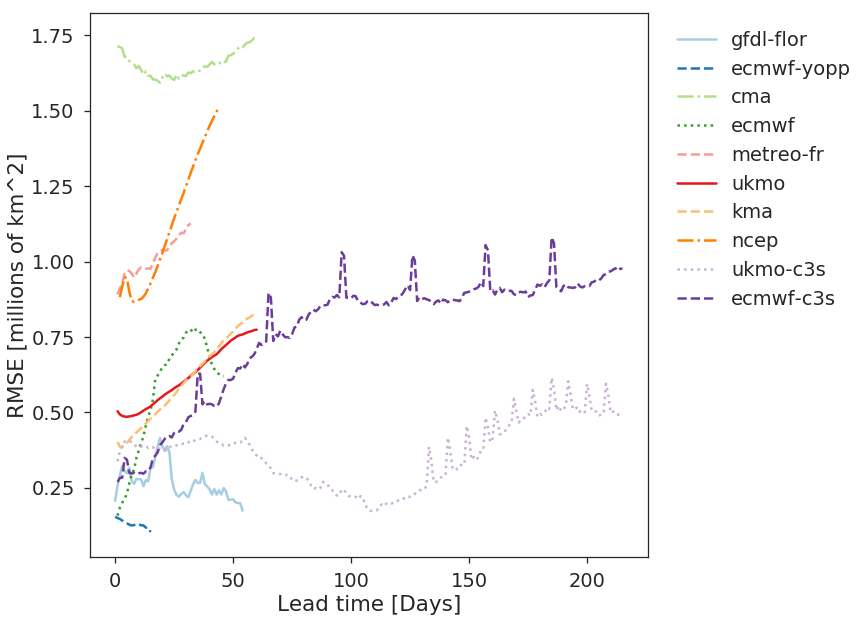

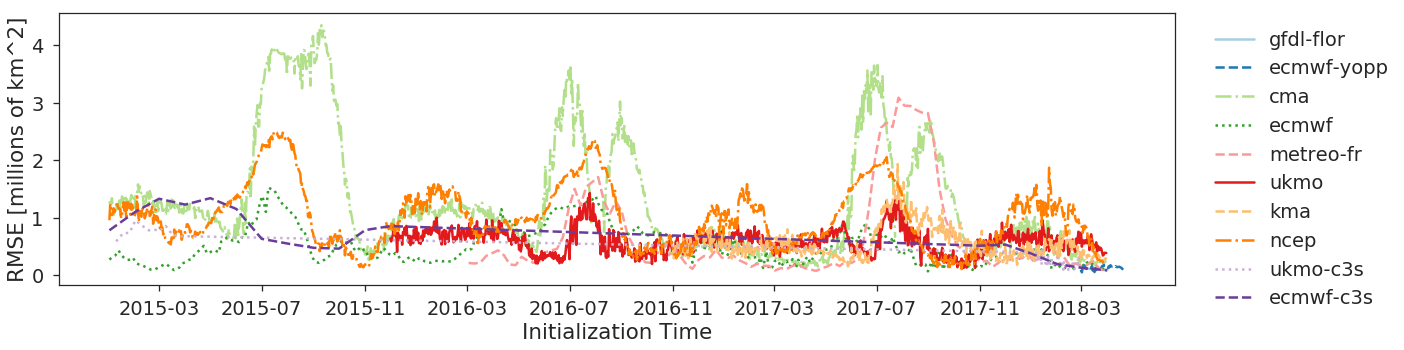

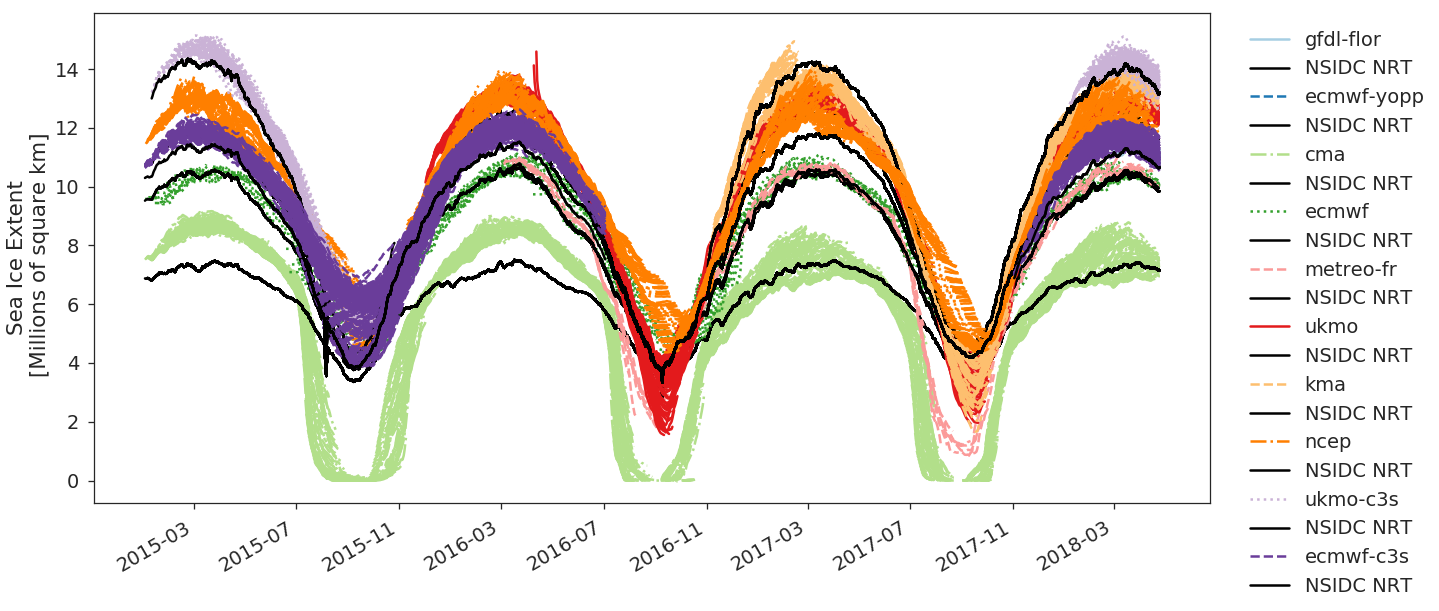

In [15]:
cmap_c = itertools.cycle(sns.color_palette("Paired", len(E.model.keys()) ))
linecycler = itertools.cycle(["-","--","-.",":","--"])

# Set up plots
f1 = plt.figure(figsize=(10,10))
ax1 = plt.subplot(1, 1, 1) # Observations
plt.ylabel('RMSE [millions of km^2]')
plt.xlabel('Lead time [Days]')
    
f2 = plt.figure(figsize=(20,5))
ax2 = plt.subplot(1, 1, 1) # Observations
plt.ylabel('RMSE [millions of km^2]')
plt.xlabel('Initialization Time')

f3 = plt.figure(figsize=(20,10))
ax3 = plt.subplot(1, 1, 1) # Observations
ax3.set_ylabel('Sea Ice Extent\n [Millions of square km]')
plt.title('')

# Loop each model
for (i, c_model) in enumerate(models_2_plot):
    # Skip prescribed models
    if not E.icePredicted[c_model]:
            continue
    print(c_model)
    
    cc = next(cmap_c)
    cl = next(linecycler)
    
    # Load in data
    # Check file exists
    nc_file = os.path.join(data_dir, 'model', c_model , 'forecast', 'agg_nc', c_model+'_extent.nc')
    if os.path.isfile(nc_file):
        ds_mrg = xr.open_dataset(nc_file)
    else:
        print('No file found... skipping...')
        continue

    # Calculate differences for each ensemble (0...N) from obseerved (-1)
    MOdiff = (ds_mrg[cvar].sel(ensemble=slice(0,ds_mrg.ensemble.size)) - ds_mrg[cvar].sel(ensemble=-1) )
    abs_max = np.max([MOdiff.min()*-1, MOdiff.max()])
    # Take average of ensemble and remove any times where we have no data in ensemble dim (missing obs)
    MOdiff_avg = MOdiff.mean(dim='ensemble')

    # Calc RMSE
    rmse_fore_time = np.sqrt( ( esio.nanSum(da=MOdiff_avg**2, dim='init_time')/MOdiff_avg.init_time.size) ).values
    rmse_init_time = np.sqrt( ( esio.nanSum(da=MOdiff_avg**2, dim='fore_time')/MOdiff_avg.fore_time.size) ).values

    
    # Plot
    ax1.plot(MOdiff.fore_time.values.astype('timedelta64[D]').astype('int'), rmse_fore_time, 
             color=cc, linestyle=cl, label=E.model[c_model]['model_label'])

    # Plot
    ax2.plot(MOdiff.init_time.values, rmse_init_time, 
             color=cc, linestyle=cl, label=E.model[c_model]['model_label'])

    # Plot pan-Arctic sea ice extent
    esio.plot_reforecast(ds=ds_mrg.sel(ensemble=slice(0,ds_mrg.ensemble.size)).sic, 
                         axin=ax3, labelin=E.model[c_model]['model_label'],
                         color=cc, linestyle=cl, marker=None, init_dot=False)
    esio.plot_reforecast(ds=ds_mrg.sel(ensemble=-1).sic.expand_dims('ensemble'), 
                     axin=ax3, labelin='NSIDC NRT',
                     color='k', marker=None, init_dot=False)
    f3.autofmt_xdate()
    
ax1.legend(loc='upper left',bbox_to_anchor=(1.02, 1))
ax2.legend(loc='upper left',bbox_to_anchor=(1.02, 1))
ax3.legend(loc='upper left',bbox_to_anchor=(1.02, 1))

f_out = os.path.join(fig_dir,'panArctic_'+runType+'_RMSE_fore_time.png')
f1.savefig(f_out,bbox_inches='tight',dpi=200)
f_out = os.path.join(fig_dir,'panArctic_'+runType+'_RMSE_init_time.png')
f2.savefig(f_out,bbox_inches='tight',dpi=200)
f_out = os.path.join(fig_dir,'panArctic_'+runType+'_extent_timeseries.png')
f3.savefig(f_out,bbox_inches='tight',dpi=200)